# GARCH

The ARCH model is a symmetric model, which implies that a positive shock has the same influence on the conditional variance as a negative shock of the same size.

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^p_{i=1}\alpha_i \epsilon_{t-1}^2 $$

where $r_t$ is the return series with its mean $\mu$, $\epsilon_t$ the error term and $\sigma_t^2$ the conditional variance. 

$z_t$ is assumed to be an I.I.D. process with $z_t \sim \mathcal{N}(0,1)$. 

To impose that the conditional variance is always nonnegative the parametric constraints are $\omega > 0$ and $\alpha_i \geq 0$. 

An extended form of the ARCH(p) model is the generalized autoregressive conditional heteroskedasticity (GARCH(p,q)) model by Bollerslev (1986).

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^q_{i=1}\alpha_i \epsilon_{t-i}^2 + \sum^p_{j=1}\beta_j \sigma_{t-j}^2$$

The parametric restrictions for the GARCH model are: $\omega > 0$ and $\alpha_i \geq 0 $ $ \forall i$, $\beta_j \geq 0 $ $ \forall j$, to guarantee that $\sigma_t^2$ is always positive and $\alpha_i + \beta_j < 1 $ $ \forall i, j$ to guarantee a covariance stationary process. 

The GARCH model has a symmetric form similar to the ARCH model and therefore does
not allow for different responses to positive or negative shocks, which is considered as a
downside of the GARCH model.

### Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(2)

,open,high,low,close,return,RV,lnRV
Date,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501


In [ ]:
# Train-Test Split 
dfs = {}
for h in [1, 3, 7, 30]:
    
    df_h = df[['return', 'lnRV']].copy()
    df_h.dropna(inplace=True)

    # Split the data into training and testing sets by the cutoff date
    cutoff_date='2024-01-01'
    r_train, r_test = df_h['return'][:cutoff_date], df_h['return'][cutoff_date:]
    lnRV_test = df['lnRV'].shift(-h)[cutoff_date:]
    
    # Shift the index to match the corrected dates
    temp_index = lnRV_test.index[h:] 
    lnRV_test.dropna(inplace=True)
    lnRV_test.index = temp_index
    
    test_size = len(lnRV_test)  
    dfs[h] = {'r_train': r_train, 'r_test': r_test, 'lnRV_test': lnRV_test}
    print(f"Testing Set Size for {h}D forecast:", test_size)
    print(f"Testing Period for {h}D forecast starts on:", lnRV_test.index[0])

Testing Set Size for 1D forecast: 424
Testing Set for 1D starts on: 2024-01-02
Testing Set Size for 3D forecast: 422
Testing Set for 3D starts on: 2024-01-04
Testing Set Size for 7D forecast: 418
Testing Set for 7D starts on: 2024-01-08
Testing Set Size for 30D forecast: 395
Testing Set for 30D starts on: 2024-01-31


The training set is the same for all forecast horizons. 

### Finding the optimal GARCH model for each forecast horizon using Training Data

### Information Criteria
The selection of appropriate orders for GARCH models in this project is guided by information criteria such as the **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)**, which help balance model fit against complexity. AIC tends to favor more parameterized models that may better capture the dynamics of financial volatility, making it particularly useful when the primary objective is **forecasting accuracy** in applications like risk management. In contrast, BIC imposes a stronger penalty on additional parameters, often leading to the selection of more parsimonious models, which is advantageous when seeking a **robust and interpretable** specification, especially with larger datasets. Hence, both criteria are considered to identify GARCH(p,q) orders that not only fit the observed volatility clustering well but also avoid overfitting.

In [4]:
def report_ic(p, o, q, h):
    model = arch_model(dfs[h]['r_train'], vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic
    return aic, bic

In [36]:
estat = pd.DataFrame(columns=['AIC', 'BIC'])
for p in [1, 2]:
    for q in [1, 2]:
        aic, bic = report_ic(p, 0, q, h)
        estat.loc[f'GARCH({p},{q})'] = [aic, bic]
print(estat.T)

      GARCH(1,1)   GARCH(1,2)   GARCH(2,1)   GARCH(2,2)
AIC -4737.435574 -4736.087015 -4735.435573 -4713.961102
BIC -4715.791766 -4709.032256 -4708.380814 -4681.495391


Based on the AIC and BIC values, GARCH(1,1) is chosen for the best AIC/BIC balance.

In [18]:
# Store the best garch model order
best_orders = (1, 1)

### Diagnostic Checking
In this section, Ljung-Box test is done to test for null hypothesis that there is no autocorrelation left in the residuals after GARCH model fit. 

In [25]:
p, q = best_orders

# Fit the GARCH model with the best orders
model = arch_model(dfs[1]['r_train'], vol='Garch', p=p, o=0, q=q, rescale=False)
results = model.fit(disp='off')

# Extract standardized residuals and squared residuals
std_residuals = results.std_resid
squared_residuals = std_residuals ** 2

# Ljung-Box test on residuals (check mean dynamics)
lb_test_resid = acorr_ljungbox(std_residuals, lags=[10, 20], return_df=True)

# Ljung-Box test on squared residuals (check volatility clustering)
lb_test_squared = acorr_ljungbox(squared_residuals, lags=[10, 20], return_df=True)
    
print("Residuals:\n", lb_test_resid, "\nSquared Residuals:\n", lb_test_squared)

Residuals:
       lb_stat  lb_pvalue
10  10.570728   0.391924
20  25.339622   0.188746 
Squared Residuals:
       lb_stat  lb_pvalue
10   6.466798   0.774640
20  11.927692   0.918542


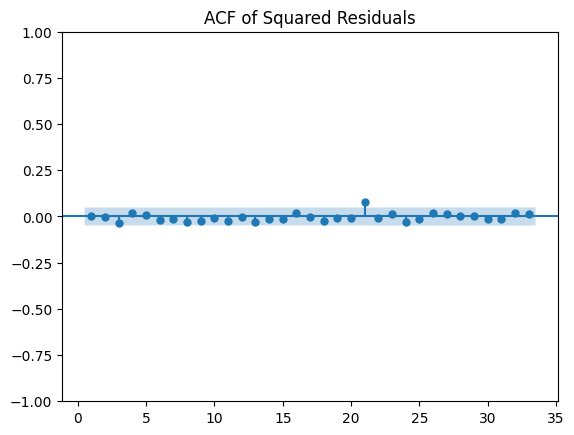

In [37]:
# Plot ACF and PACF of residuals
plot_acf(squared_residuals, zero=False, title='ACF of Squared Residuals')
plt.show()

From the above results, we see that all lags stay within confidence bounds. Hence, we can conclude that the selected GARCH models adequately captures volatility dynamics for each forecast horizon, and there is no need for model complexity increases.

### Forecast Results on the Testing Period

In [29]:
def predict(log_returns, p, o, q, h):
    """
    Parameters:
    log_returns (array-like): Daily log return series r₁,..rₙ for the asset

    p (int): order of the GARCH term
    o (int): order of the asymmetric term
    q (int): order of the ARCH term

    h (int): forecast horizon (number of days ahead)
    
    Returns:
    forecast (float): forecasted value of σ²ₙ₊₁
    """
    # Step 1: Estimate GARCH parameters
    model = arch_model(log_returns.values, vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    
    # Step 2: Compute h-day-ahead forecast of σ²
    forecast = results.forecast(horizon=h).variance.values[-1, -1]
    
    return forecast

In [34]:
def get_pred(p, o, q, h):

    pred = []
    
    r_train, r_test = dfs[h]['r_train'], dfs[h]['r_test']
    lnRV_test = dfs[h]['lnRV_test']
    
    for i in range(len(lnRV_test)):
        log_returns = pd.concat([r_train, r_test[:i]])
        forecast = predict(log_returns, p, o, q, h)
        pred.append(np.log(forecast))
    pred = pd.DataFrame(pred, index = lnRV_test.index, columns=['Predicted'])
    pred.to_csv(f'../res/GARCH({p},{o},{q})_{h}D.csv', index=False)
    return pred

In [31]:
def plot_pred(pred, actual, p, o, q, h):
    plt.figure(figsize=(8, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'GARCH({p},{o},{q})_{h}D-Ahead Forecast')
    plt.legend()
    plt.savefig(f'../res/GARCH({p},{o},{q})_{h}D-Ahead Forecast.png')

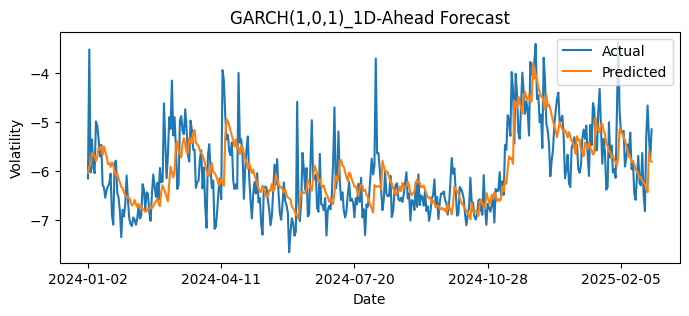

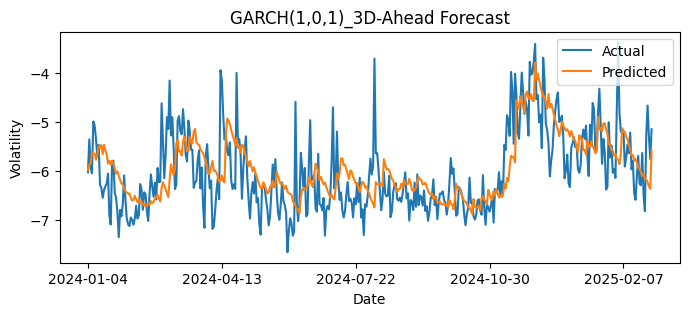

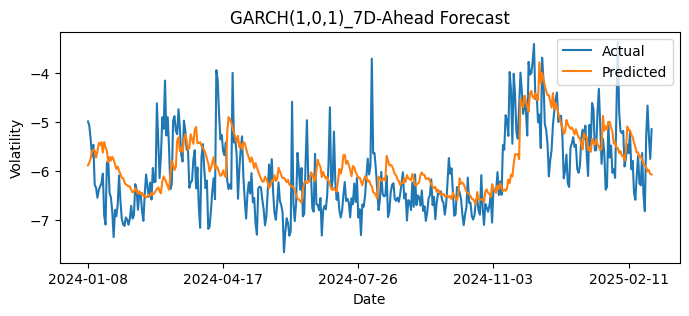

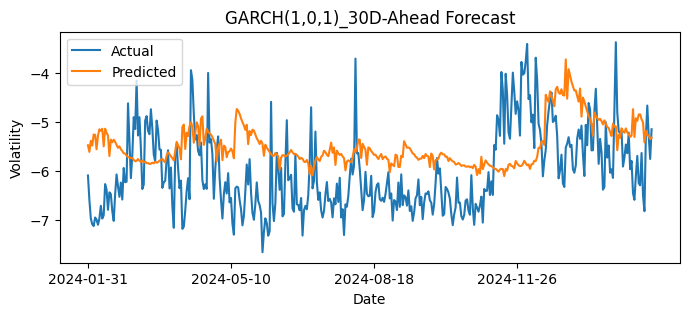

In [35]:
for h in [1,3,7,30]:
    p, q = best_orders
    pred = get_pred(p, 0, q, h)
    plot_pred(pred, dfs[h]['lnRV_test'], p, 0, q, h)

### EGARCH


Exponential Generalized Autoregressive Conditional Heteroskedasticity

The **EGARCH** model, introduced by **Nelson (1991)**, is an advanced volatility modeling technique that improves upon traditional GARCH models by:

- Accounting for **asymmetric effects** (e.g., leverage effects, where negative shocks increase volatility more than positive ones).
- Ensuring **positive volatility** without parameter restrictions (due to exponential form).
- Capturing **"bad news" (negative shocks)** having a larger impact on volatility than "good news."

$$\ln(\sigma_t^2) = \omega + \sum \alpha_i \left( \frac{|u_{t-i}|}{\sigma_{t-i}} \right) + \sum \gamma_i \left( \frac{u_{t-i}}{\sigma_{t-i}} \right) + \sum \beta_j \ln(\sigma_{t-j}^2) $$
- $\gamma_i$ captures **asymmetry** (negative shocks increase volatility more).
- **Leverage Effect**: $\gamma_i < 0$ implies negative returns increase volatility more than positives.
- **No Parameter Constraints**: Unlike GARCH, coefficients can be negative.

#### Testing the Significance of the Asymmetric Term in EGARCH

In [38]:
model = arch_model(dfs[1]['r_train'], vol='Garch', p=1, o=1, q=1, rescale=False)
results = model.fit(disp='off')
print(results.pvalues['gamma[1]'])

0.7731298675432869


The EGARCH model shows no statistically significant leverage effect (p-value associated with the negative shocks is more than 0.05), failing to support the hypothesis that negative returns increase future volatility more than positive returns of the same magnitude. Thus, EGARCH is not preferred over symmetric GARCH for this dataset. 